In [3]:
import tensorflow as tf
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Flatten, Dropout

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5
train_set = tf.data.Dataset.from_tensor_slices(X_train).shuffle(60000).batch(256)

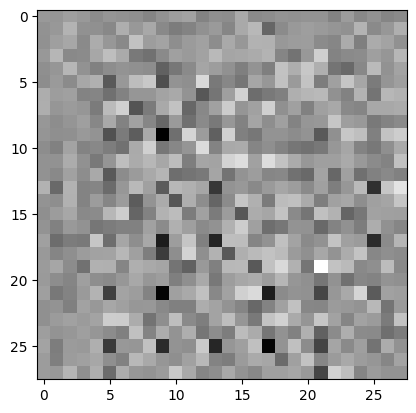

In [5]:
def m_generator():
    model = Sequential()
    model.add(Dense(7 * 7 * 256, use_bias = False, input_shape = (100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides = (2,2 ), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation = 'tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

m_generator = m_generator()

noise = tf.random.normal([1, 100])
generated_image = m_generator(noise, training = False)

plt.imshow(generated_image[0,:,:,0], cmap = 'gray')

In [6]:
def m_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape=[28, 28, 1]))

    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [7]:
m_discriminator = m_discriminator()

decision = m_discriminator(generated_image)

print(decision)

tf.Tensor([[-0.00069277]], shape=(1, 1), dtype=float32)


In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [9]:
def loss_discriminator(true_output, fake_output):
    true_loss = cross_entropy(tf.ones_like(true_output), true_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = true_loss + fake_loss
    
    return total_loss

In [10]:
def loss_generator(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
seed = tf.random.normal([16, 100])

In [12]:
@tf.function
def train_st(images):
    noise = tf.random.normal([256, 100])

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_image = m_generator(noise, training = True)

        true_output = m_discriminator(images, training = True)
        fake_output = m_discriminator(generated_image, training = True)

        generator_loss = loss_generator(fake_output)
        discriminator_loss = loss_discriminator(true_output, fake_output)

    grad_generator = generator_tape.gradient(generator_loss, m_generator.trainable_variables)
    grad_discriminator = discriminator_tape.gradient(discriminator_loss, m_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_generator, m_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_discriminator, m_discriminator.trainable_variables))

In [13]:
def plot_generated_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        
    plt.show()

In [14]:
def train(ds, epochs):
    for epoch in range(epochs):

        for img_batch in ds:
            train_st(img_batch)

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}")
            plot_generated_images(m_generator, epoch + 1, seed)

Epoch 1


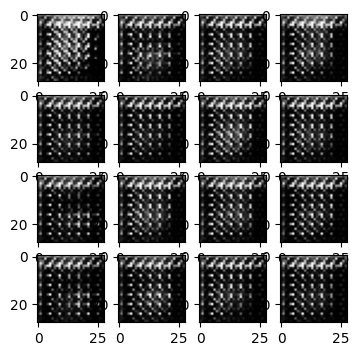

Epoch 11


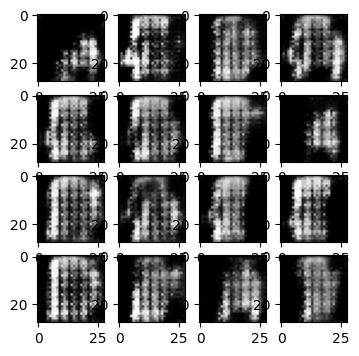

Epoch 21


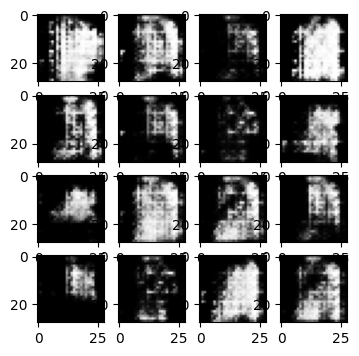

Epoch 31


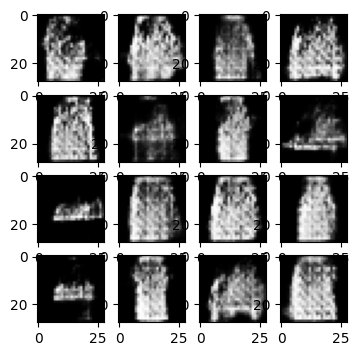

Epoch 41


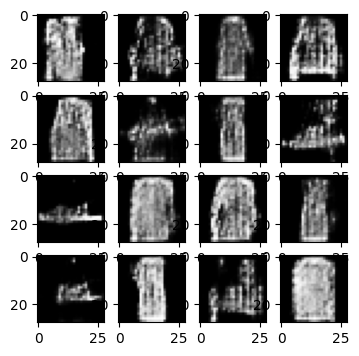

Epoch 51


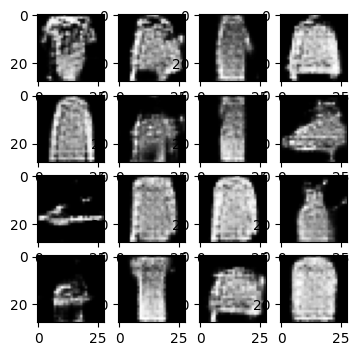

Epoch 61


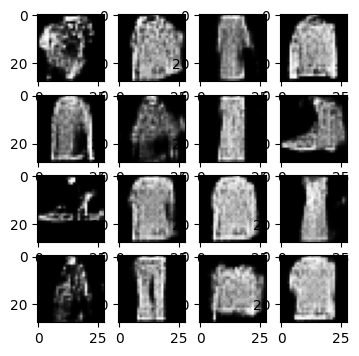

Epoch 71


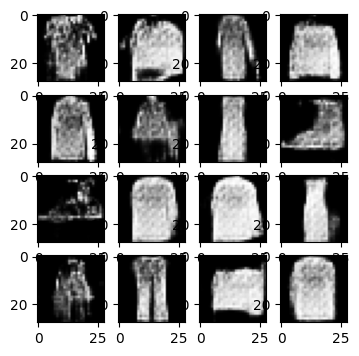

Epoch 81


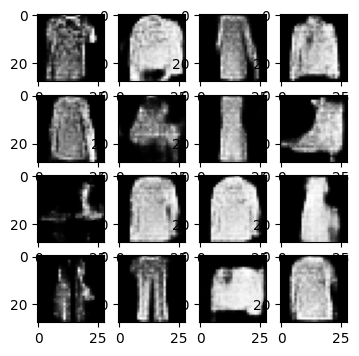

Epoch 91


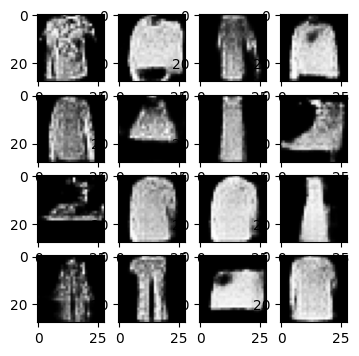

In [15]:
train(train_set, 100)